# Yelp Review Classifier
This notebook serves as a challenge to implement and explore LSTM and Convolution model over the new Yelp review dataset. You have to fill up all the blanks with the hyperparameters that helps you get the best accuracy and loss.

In [1]:
##import the required libraries and APIs
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.14.0


## Downloading the TensorFlow `yelp_popularity_review` dataset

> Make sure tensorflow_datasets is installed

In [2]:
##load the yelp reviews dataset
data, info = tfds.load("yelp_polarity_reviews", with_info=True, as_supervised=True)

In [3]:
train_data, test_data = data['train'], data['test']

train_sentences = []
test_sentences = []

train_labels = []
test_labels = []

In [4]:
for sent, label in train_data:
    train_sentences.append(str(sent.numpy().decode('utf8')))
    train_labels.append(label.numpy())

for sent, label in test_data:
    test_sentences.append(str(sent.numpy().decode('utf8')))
    test_labels.append(label.numpy())

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [5]:
len(train_sentences)

560000

In [6]:
t = Tokenizer(oov_token="<oov>")
t.fit_on_texts(train_sentences)

In [7]:
print(len(t.word_index))

250065


In [8]:
tts = t.texts_to_sequences(train_sentences)
len_dist = [len(i) for i in tts]
del t
del tts

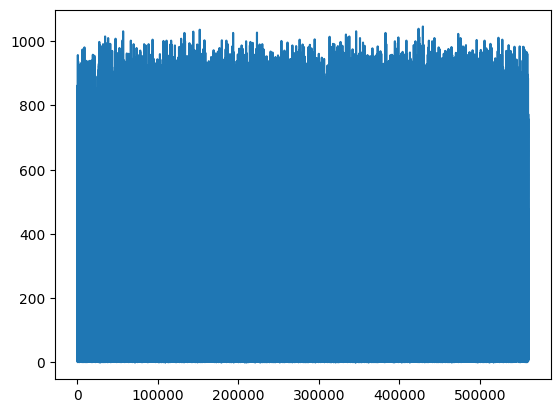

In [9]:
import matplotlib.pyplot as plt
plt.plot(len_dist)
plt.show()
del len_dist

In [10]:
##define the parameters for tokenizing and padding
vocab_size = 250065 + 1
embedding_dim = 32
max_length = 1000
padding_type = 'post'
trunc_type='post'
oov_tok = "<OOV>"

In [11]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

##training sequences and labels
train_seqs = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_seqs,maxlen=max_length, truncating=trunc_type)

##testing sequences and labels
test_seqs = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_seqs,maxlen=max_length)

## Explore the LSTM & CNN model with the following layers:
1. Embedding layer
2. Try two bidirectional LSTM layers or a Conv1D layer or both.
3. Dense layer with 24 nodes
4. Output Dense layer with `sigmoid` activation

In [12]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          8002080   
                                                                 
 bidirectional (Bidirection  (None, 1000, 128)         49664     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8095073 (30.88 MB)
Trainable params: 80950

In [12]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(64,12, activation='relu'),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          8002080   
                                                                 
 conv1d (Conv1D)             (None, 989, 64)           24640     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8028833 (30.63 MB)
Trainable params: 8028833 (30.63 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [16]:
num_epochs = 2
lstm_history = lstm_model.fit(
    train_padded,
    train_labels,
    epochs=num_epochs,
    validation_data=(test_padded, test_labels)
    )

Epoch 1/2
17500/17500 [==============================] - 2017s 114ms/step - loss: 0.1650 - accuracy: 0.9355 - val_loss: 0.1152 - val_accuracy: 0.9578
Epoch 2/2
17500/17500 [==============================] - 1891s 108ms/step - loss: 0.0956 - accuracy: 0.9646 - val_loss: 0.1026 - val_accuracy: 0.9620


In [14]:
num_epochs = 2
cnn_history = cnn_model.fit(
    train_padded,
    train_labels,
    epochs=num_epochs,
    validation_data=(test_padded, test_labels)
    )

Epoch 1/2
17500/17500 [==============================] - 299s 16ms/step - loss: 0.1661 - accuracy: 0.9340 - val_loss: 0.1265 - val_accuracy: 0.9523
Epoch 2/2
17500/17500 [==============================] - 143s 8ms/step - loss: 0.1065 - accuracy: 0.9601 - val_loss: 0.1160 - val_accuracy: 0.9565


## Visualise the accuracy and loss

In [15]:
import matplotlib.pyplot as plt

def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
plot_metrics(lstm_history, "accuracy")
plot_metrics(lstm_history, "loss")

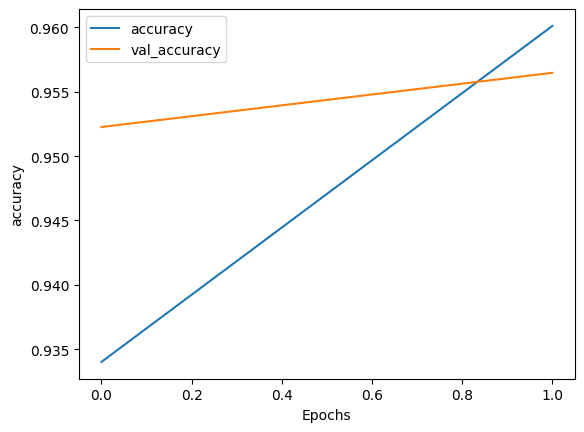

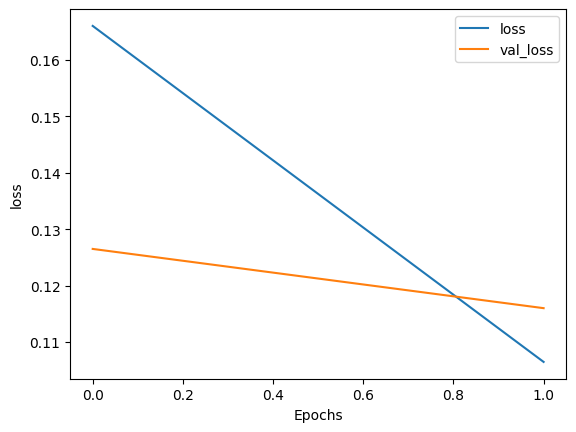

In [16]:
plot_metrics(cnn_history, "accuracy")
plot_metrics(cnn_history, "loss")

## Classify new reviews

In [ ]:
sentence = ["the restaurant served a delicious pasta", "the restaurant didn't have a decent ambience"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(lstm_model.predict(padded))

In [17]:
sentence = ["the restaurant served a delicious pasta", "the restaurant didn't have a decent ambience"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(cnn_model.predict(padded))

1/1 [==============================] - 0s 131ms/step
[[0.49787533]
 [0.56825656]]
